# This notebook computes predictions for lensing of dwarf galaxies for various upcoming lensing surveys.

In [1]:
#import camb
#pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
#from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
from power_spectra import *
from astropy.cosmology import Planck15 as cosmo #use Planck15 if you can
import astropy.units as u
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams["font.family"] = "serif"
from scipy.signal import savgol_filter
import scipy.integrate as integrate
import cosmology as cosmology

plt.rcParams['text.usetex'] = False
#rc('text', usetex=False)
cosmo_h=cosmo.clone(H0=70)

In [2]:
# Option: use shape noise only (shapenoiseonly=1), or all sources of noise
shapenoiseonly = 0

In [3]:
# Read in the COSMOS GALAXY SMF
SMF_prof=np.genfromtxt('./cosmos2015_dic2017_smf_z01-04_STY0.txt',names=('log_m','log_phi','log_phi_inf','log_phi_sup'))
log_m=SMF_prof['log_m']
log_phi=SMF_prof['log_phi']

## Survey and Lens Sample Parameters

In [ ]:
# COSMOS Survey
z_source=np.atleast_1d([1.2])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=39.0 #n sources per arcmin^2
area=1.64 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 7.9
Ms_max = 8.1

resultfile='cosmos_7.9_8.1_0_0.25_smooth.txt'
headernote='This is the DS profile with errors for COSMOS Survey\nRP DS DS_error'

# Corresponding DS file from Felipe
#DS_prof=np.genfromtxt('./BolPlanck_r_DS_50.txt',names=('rp','DS'))
DS_prof=np.genfromtxt('./dwarf_smooth_model_8.txt',names=('rp','DS'))

In [ ]:
# HSC wide
z_source=np.atleast_1d([0.81])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=18.5 #n sources per arcmin^2
area=1000.0 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 7.9
Ms_max = 8.1

resultfile='hscwide_7.9_8.1_0_0.25_smooth.txt'
headernote='This is the DS profile with errors for HSC wide\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./dwarf_smooth_model_8.txt',names=('rp','DS'))

In [51]:
# LSST wide
z_source=np.atleast_1d([1.2])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=30.0 #n sources per arcmin^2
area=18000.0 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 8.0
Ms_max = 9.0

resultfile='lsstwide_7.9_8.1_0_0.25_smooth.txt'
headernote='This is the DS profile with errors for LSST wide\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./dwarf_smooth_model_8.txt',names=('rp','DS'))

In [75]:
# Euclid wide
z_source=np.atleast_1d([0.9])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=30.0 #n sources per arcmin^2
area=15000.0 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this  value from data

# Range of lens M*
Ms_min = 8.9
Ms_max = 9.1

resultfile='euclid_8.9_9.1_0_0.25_smooth_z0.9.txt'
headernote='This is the DS profile with err ors for Euclid wide\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./dwarf_smooth_model_9.txt',names=('rp','DS'))

In [ ]:
# WFIRSTHLS
z_source=np.atleast_1d([1.1])   # mean redshift of sources
sigma_gamma=0.28
n_s_arcmin=45.0 #n sources per arcmin^2
area=2400.0 #in deg^-2

z_lens_min=0.0
z_lens_max=0.25
z_lens_mean =0.18 # Got this value from data

# Range of lens M*
Ms_min = 7.9
Ms_max = 8.1

resultfile='wfirst_7.9_8.1_0_0.25_smooth.txt'
headernote='This is the DS profile with errors for WFIRSTHLS\nRP DS DS_error'

# Corresponding DS file from Felipe
DS_prof=np.genfromtxt('./dwarf_smooth_model_8.txt',names=('rp','DS'))

In [76]:
z_lens=np.atleast_1d([z_lens_mean])

In [77]:
# Get the number density of lenses by integrating the SMF
# and shot noise

SMF = interp1d(log_m, log_phi, kind=3)
x_SMF = np.linspace(0,13,10000)
Phi_interp1d = SMF(x_SMF)
SMF_new = interp1d(x_SMF, pow(10,Phi_interp1d), kind=3)
phiintegral = integrate.quad(lambda x: SMF_new(x), Ms_min, Ms_max)[0]
n_g = phiintegral
g_shot_noise=1./n_g

In [78]:
10**(np.log10(DS_prof['rp'][0])-dlogr/2)

0.005721945352509514

In [79]:
# Set up the R binning in DS
dlogr=np.gradient(np.log10(DS_prof['rp']))[0]
rmin=0.001 #10**(np.log10(DS_prof['rp'][0])-dlogr/2)
rmax=1.9 #10**(np.log10(DS_prof['rp'][-1])+dlogr/2)
nbins=len(DS_prof['rp'])

rp_bins=np.logspace(np.log10(rmin),np.log10(rmax),nbins+1)

In [80]:
#Set up a new set of parameters for power spectra and correlation functions
PS=Power_Spectra()
PS.pk_params['kmax']=520
PS.pk_params['kmin']=1e-2
PS.pk_params['non_linear']=1
rmin=0.001
rmax=1.9

In [81]:
cosmo_params=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Odm0,'Om':cosmo.Om0,
                'As':2.14e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,
                  'w':-1,'wa':0})

In [82]:
pk,kh=PS.class_pk(z_lens,cosmo_params=cosmo_params,pk_params=pk_params,return_s8=False)
h=cosmo.h
k=kh*h
pk=pk/h**3
rho=PS.Rho_crit(cosmo=cosmo)*cosmo.Om0

In [11]:
#Setting up the Hankel Transform
#This deals with the interpolation over the Bessel Functions
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=PS.pk_params['kmax'],j_nu=[2],n_zeros=80000,kmin=PS.pk_params['kmin'],prune_r=0)
%time HT_inv=hankel_transform(rmin=PS.pk_params['kmin'],rmax=PS.pk_params['kmax'],kmax=rmax,j_nu=[2],n_zeros=80000,kmin=rmin,prune_r=50)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

changed kmax to 5135.622301840683  to cover rmin
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 81000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 82000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 83000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 84000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 85000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 86000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 87000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 88000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 89000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 90000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 91000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 92000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 93000
j-nu= 2  not enough zeros to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 195000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 196000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 197000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 198000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 199000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 200000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 201000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 202000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 203000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 204000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 205000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 206000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 207000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 309000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 310000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 311000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 312000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 313000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 314000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 315000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 316000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 317000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 318000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 319000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 320000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 321000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 422000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 423000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 424000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 425000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 426000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 427000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 428000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 429000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 430000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 431000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 432000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 433000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 434000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 536000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 537000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 538000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 539000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 540000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 541000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 542000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 543000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 544000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 545000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 546000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 547000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 548000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 650000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 651000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 652000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 653000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 654000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 655000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 656000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 657000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 658000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 659000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 660000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 661000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 662000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 763000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 764000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 765000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 766000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 767000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 768000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 769000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 770000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 771000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 772000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 773000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 774000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 775000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 116000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 117000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 118000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 119000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 120000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 121000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 122000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 123000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 124000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 125000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 126000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 127000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 128000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 229000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 230000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 231000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 232000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 233000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 234000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 235000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 236000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 237000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 238000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 239000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 240000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 241000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 342000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 343000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 344000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 345000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 346000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 347000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 348000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 349000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 350000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 351000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 352000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 353000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 354000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 456000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 457000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 458000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 459000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 460000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 461000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 462000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 463000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 464000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 465000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 466000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 467000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 468000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 569000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 570000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 571000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 572000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 573000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 574000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 575000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 576000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 577000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 578000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 579000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 580000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 581000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 682000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 683000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 684000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 685000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 686000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 687000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 688000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 689000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 690000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 691000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 692000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 693000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 694000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 795000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 796000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 797000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 798000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 799000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 800000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 801000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 802000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 803000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 804000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 805000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 806000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 807000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to

In [83]:
x=HT_inv.k[2]>DS_prof['rp'].max()
DS2=DS_prof['DS'][-1]*DS_prof['rp'][-1]/HT_inv.k[2][x]
DS2=np.append(DS_prof['DS'],DS2)
rp2=np.append(DS_prof['rp'],HT_inv.k[2][x]) #this doesnot help
#DS2 = savgol_filter(DS2, 5, 3) # window size 51, polynomial order 3

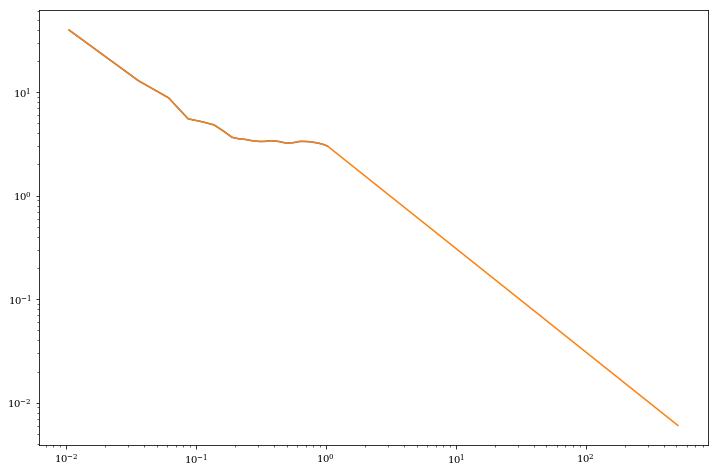

In [84]:
plt.plot(DS_prof['rp'],DS_prof['DS'])
plt.plot(rp2,DS2)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [85]:
k2,p_gk2=HT_inv.projected_correlation(k_pk=rp2,pk=DS2,j_nu=2)
p_gk2*=(2*np.pi)**2 #factors due to fourier convention
# p_gk2*=(HT.kmax[2]**2/HT.rmax[2]**2) #https://www.gnu.org/software/gsl/doc/html/dht.html
#p_gk2 = savgol_filter(p_gk2, 21, 3) # window size 51, polynomial order 3

In [86]:
# This is just for the clustering term
# In the future could do more sophisticated model for bias of clustering
# by measuring the clustering in the simulation
# Could do a b1 and b2 term
# shouldnt have a large impact on the errors though
b_g=1
p_g=b_g**2*pk[0]
p_gk=b_g*pk[0]*rho

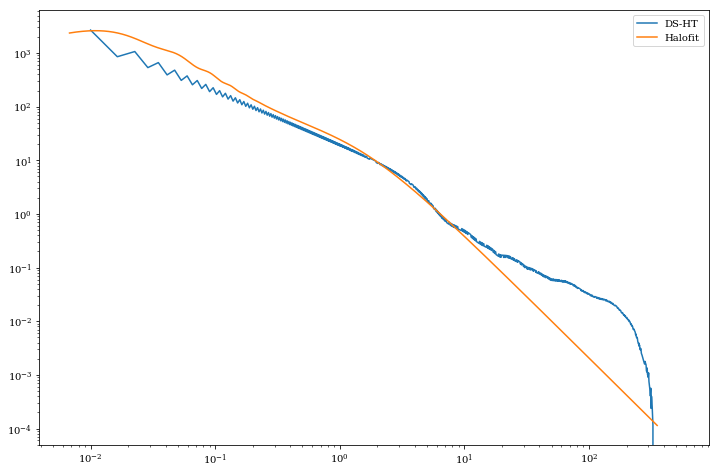

In [87]:
plt.loglog(k2,p_gk2,label='DS-HT') #sim profile, extrapolated and then inv-HT
plt.loglog(k,p_gk,label='Halofit')
plt.legend()
plt.show()

In [88]:
r_th,DS_th2=HT.projected_correlation(k_pk=k2,pk=p_gk2,j_nu=2)
r_th,DS_th=HT.projected_correlation(k_pk=k,pk=p_gk,j_nu=2)

In [89]:
rp,DS_th_b=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th) #bin the theory predictions
rp,DS_th_b2=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th2) #bin the theory predictions

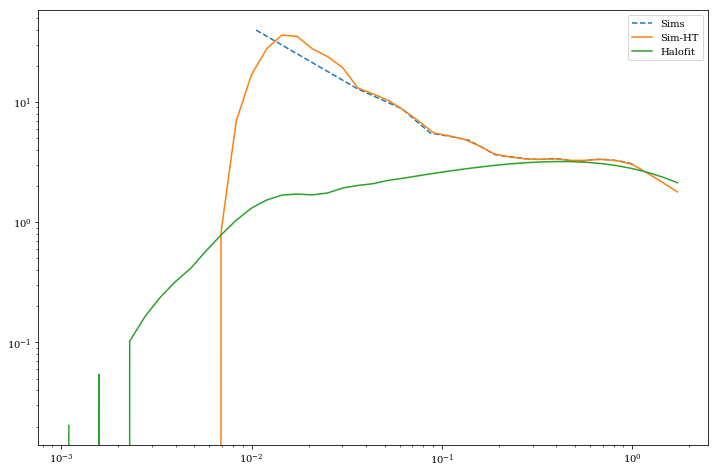

In [90]:
plt.plot(DS_prof['rp'],DS_prof['DS'],'--',label='Sims')
plt.plot(rp,DS_th_b2,label='Sim-HT') # Extrapolatred profile from sims, inv-HT to get power spectra and then HT back
plt.plot(rp,DS_th_b,label='Halofit')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# g-g Lensing covariance

We are using the real-space DS(r_p) covariance expression from Sukhdeep Singh's paper, Eq 10.
http://adsabs.harvard.edu/abs/2016arXiv161100752S

Here we are using the part withuot the curly brackets (as explained later in the text, if you subtract DS around randoms to get the optimal estimator, you get rid of the curly brackets term)

We are ignoring the connected $T_{g \gamma g \gamma}$ term, as it’s unlikely to be very important and is so much harder to calculate, and we are just keeping the $(P_{gg} + N_g) (P_{\gamma \gamma} + N_\gamma) + P_{g \gamma}^2$ stuff, so you have lens clustering and shot noise, cosmic shear and shape noise, and cosmic variance terms.

In [91]:
# This is the comoving distance between zlens_min and zlens_max
# line of sight window lenght
# redshift bins lens Mpc
L_W=cosmo.angular_diameter_distance(z_lens_max)-cosmo.angular_diameter_distance(z_lens_min)
L_W=L_W.value

area_comoving=area*(np.pi/180)**2*cosmo.angular_diameter_distance(z_lens_mean)**2

In [92]:
c=cosmology.Cosmo(H0=70, omega_m = 0.3)

In [93]:
c.V(z_lens_min,z_lens_max)

4291917946.35439

In [94]:
volume = c.V(z_lens_min,z_lens_max) * 1.64/(4*np.pi*(180/np.pi)**2)
nlens = phiintegral * volume

In [95]:
nlens

496.0074952421761

In [96]:
#check H0 and comoving physical
sigma_crit=PS.sigma_crit(zl=z_lens,zs=z_source,cosmo=cosmo)
sigma_crit=sigma_crit[0,0].value

In [97]:
d2r=np.pi/180.
n_s=n_s_arcmin*3600/d2r**2
shape_noise=sigma_gamma**2/n_s

In [98]:
l,cl_kappa_kappa=PS.kappa_cl(zs1=z_source,p_zs1=[1],zs2=z_source,p_zs2=[1],zl_max=z_source,n_zl=100,
                             l=np.arange(5.e5),cosmo=cosmo,cl_z_func=PS.pk_l_z)
chi=cosmo.angular_diameter_distance(z_lens)
k_l=(l+0.5)/chi
cl_intp=interp1d(k_l,cl_kappa_kappa,bounds_error=False,fill_value=0)

/Users/yifei/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/power_spectra.py:279: RuntimeWarning: divide by zero encountered in true_divide
  f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017


In [99]:
cl_intp(k)*u.Mpc**2+shape_noise*chi**2

<Quantity [3.65227452e-04, 3.66611519e-04, 3.67998596e-04, ...,
           9.23210385e-05, 9.23210333e-05, 9.23210280e-05] Mpc2>

In [100]:
l,cl_kappa_kappa=PS.kappa_cl(zs1=z_source,p_zs1=[1],zs2=z_source,p_zs2=[1],zl_max=z_source,n_zl=100,
                             l=np.arange(5.e5),cosmo=cosmo,cl_z_func=PS.pk_l_z)
chi=cosmo.angular_diameter_distance(z_lens)
k_l=(l+0.5)/chi
cl_intp=interp1d(k_l,cl_kappa_kappa,bounds_error=False,fill_value=0)

# approximation of convergence power spectrum p_kappa_kappa
# integration over LOS window function

# cl_z_func=PS.cl_z: Returns cl_\kappa\kappa. Multiply with chi**2 to get in units of projected power spectra (approximate, older version. Not recommended for main results).
# cl_z_func=PS.pk_l_z: Returns P_\kappa\kappa, in units of projected power spectra. Introduced in updated version. Use for main results.

# YIFEI CHECK HERE!!!
# Comment out here to change
if shapenoiseonly == 1:
    p_kappa_kappa=sigma_crit**2*(cl_intp(k)*0+shape_noise)*chi**2 #shape noise only    
else:
#   p_kappa_kappa=sigma_crit**2*(cl_intp(k)+shape_noise)*chi**2  #all noise ... for older approximate version
    p_kappa_kappa=sigma_crit**2*(cl_intp(k)*u.Mpc**2+shape_noise*chi**2)  #all noise .. for updated version (chi**2 is now inside brackets)

/Users/yifei/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/power_spectra.py:279: RuntimeWarning: divide by zero encountered in true_divide
  f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017


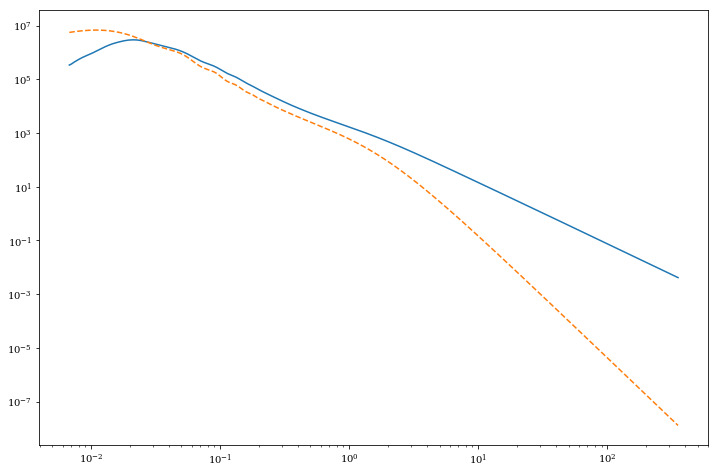

In [101]:
plt.plot(k,p_kappa_kappa*p_g/L_W)
plt.plot(k,p_gk**2,'--')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [102]:
taper_kw=dict({'large_k_lower':500,'large_k_upper':PS.pk_params['kmax'],'low_k_lower':PS.pk_params['kmin'],
               'low_k_upper':PS.pk_params['kmin']*1.2})

In [103]:
# Pgg x Pgammagamma

if shapenoiseonly == 1:
    r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g*0+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw) #shape noise only
else:
    r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw) #all noise


r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [104]:
#### ***** YIFEI CHECK HERE

r,cov_gkgk=HT.projected_covariance(k_pk=k,pk1=p_gk,pk2=p_gk,j_nu=2,taper=True,**taper_kw)#return_Jrr=True,Jrr=Jrr
#Donot use gkgk when doing noise only
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [105]:
# Pgg x Pgammagamma

cov_ggkk_re/=(area_comoving.value*L_W)
cov_gkgk_re/=area_comoving.value

if shapenoiseonly == 1:
    cov_final=cov_ggkk_re #shape noise only    
else:
    cov_final=(cov_ggkk_re+cov_gkgk_re)#/area_comoving.value #all noise

corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)
errors_ggkk=HT.diagonal_err(cov=cov_ggkk_re)
errors_gkgk=HT.diagonal_err(cov=cov_gkgk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


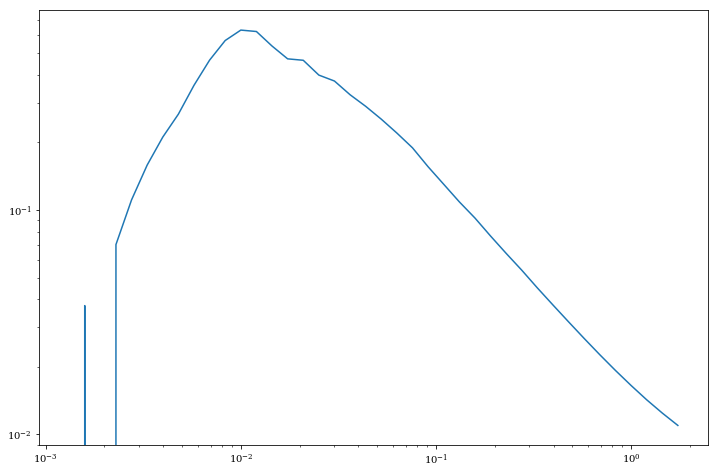

In [106]:
# Plot DS with errors here
plt.plot(r_re[1:41],errors_ggkk[1:41])
plt.xscale("log")
plt.yscale("log")
plt.show()

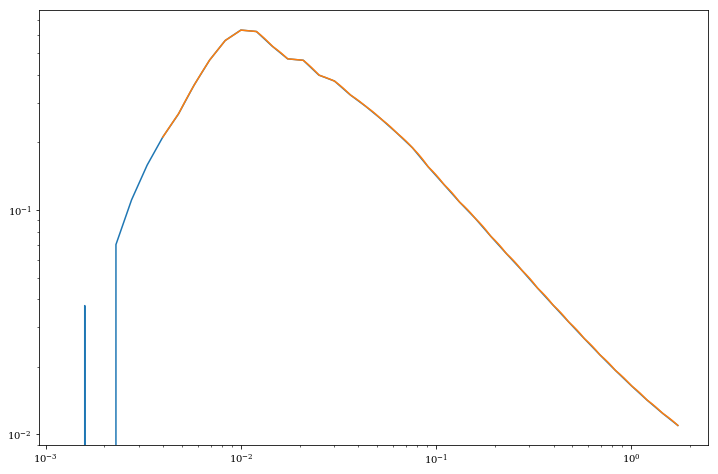

[0.0105742 0.0361123 0.0616505 0.0871886 0.1127267 0.1382648 0.163803
 0.1893411 0.2148792 0.2404173 0.2659554 0.2914936 0.3170317 0.3425698
 0.368108  0.3936461 0.4191842 0.4447224 0.4702605 0.4957986 0.5213367
 0.5468749 0.572413  0.5979511 0.6234893 0.6490273 0.6745655 0.7001036
 0.7256417 0.7511799 0.776718  0.8022561 0.8277943 0.8533324 0.8788705
 0.9044086 0.9299468 0.9554849 0.981023  1.0065612 1.0320992]
[0.00397898 0.00478345 0.00575057 0.00691323 0.00831094 0.00999125
 0.01201129 0.01443973 0.01735916 0.02086884 0.02508811 0.03016043
 0.03625828 0.04358899 0.05240182 0.06299644 0.07573308 0.09104481
 0.10945228 0.13158137 0.15818453 0.19016632 0.2286142  0.27483548
 0.3304018  0.39720253 0.47750904 0.57405196 0.69011394 0.82964137
 0.9973785  1.19902876 1.44144873 1.73288124]
[0.63011669 0.32720638 0.22431809 0.16414871 0.12694909 0.10450466
 0.08934824 0.07695164 0.06852956 0.06147873 0.05586913 0.05122932
 0.0471065  0.04363223 0.04087056 0.03810891 0.03608547 0.03418146
 0

In [107]:
noise_func = interp1d(r_re[2:41], errors_ggkk[2:41], kind=1)
x_noise = np.linspace(r_re[7],r_re[40],100000)
noise_interp1d = noise_func(x_noise)

plt.plot(r_re[1:41],errors_ggkk[1:41])
plt.plot(x_noise,noise_interp1d)
plt.xscale("log")
plt.yscale("log")
plt.xlim()
plt.show()

DS_error = noise_func(DS_prof['rp'][0:41])
print(DS_prof['rp'][0:41])
print(r_re[7:41])
print(DS_error)

In [108]:
# Save the results in a file
# save resultfile here
#result = np.array([DS_prof['rp'][1:40],DS_prof['DS'][1:40],errors_ggkk[1:40]])
result = np.array([DS_prof['rp'],DS_prof['DS'],DS_error])
result = result.T
np.savetxt(resultfile,result,fmt='%.7f',delimiter=' ',newline='\n',header=headernote,footer='')